In [70]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import optuna

import seaborn as sns
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.linear_model import LogisticRegression


from scipy.cluster.hierarchy import dendrogram

from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
import warnings
warnings.filterwarnings('ignore')

from statsmodels.stats.multitest import fdrcorrection


In [39]:
df = pd.read_csv("Breast_GSE45827.csv")


## EDA

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Columns: 54677 entries, samples to AFFX-TrpnX-M_at
dtypes: float64(54675), int64(1), object(1)
memory usage: 63.0+ MB


In [41]:
df.head(5)

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,84,basal,9.850040,8.097927,6.424728,7.353027,3.029122,6.880079,4.963740,4.408328,...,12.229711,11.852955,13.658701,13.477698,6.265781,5.016196,4.901594,2.966657,3.508495,3.301999
1,85,basal,9.861357,8.212222,7.062593,7.685578,3.149468,7.542283,5.129607,4.584418,...,12.178531,11.809408,13.750086,13.470146,6.771853,5.291005,5.405839,2.934763,3.687666,3.064299
2,87,basal,10.103478,8.936137,5.735970,7.687822,3.125931,6.562369,4.813449,4.425195,...,12.125108,11.725766,13.621732,13.295080,6.346952,5.171403,5.184286,2.847684,3.550597,3.158535
3,90,basal,9.756875,7.357148,6.479183,6.986624,3.181638,7.802344,5.490982,4.567956,...,12.111235,11.719215,13.743108,13.508861,6.610284,5.193356,5.086569,3.031602,3.524981,3.272665
4,91,basal,9.408330,7.746404,6.693980,7.333426,3.169923,7.610457,5.372469,4.424426,...,12.173642,11.861296,13.797774,13.542206,6.414354,5.040202,5.235318,2.956232,3.445501,3.193947


In [42]:
df.notnull().count()

samples            151
type               151
1007_s_at          151
1053_at            151
117_at             151
                  ... 
AFFX-ThrX-5_at     151
AFFX-ThrX-M_at     151
AFFX-TrpnX-3_at    151
AFFX-TrpnX-5_at    151
AFFX-TrpnX-M_at    151
Length: 54677, dtype: int64

In [43]:
df.notnull().count().min(), df.notnull().count().max()

(151, 151)

In [44]:
genes_matrix = df.drop(["samples", "type"], axis=1).values
genes_names = df.columns[2:]




color_map = {
    "normal": "#2ca02c",  # Olive green, good for 'normal' to symbolize health
    "HER": "#1f77b4",    # Mutated blue, a stark contrast for highlighting HER
    "luminal_B": "#9467bd",  # Soft purple, distinct yet clearly differentiable
    "luminal_A": "#8c564b",  # Rosy brown, subtle and distinct from luminal_B
    "cell_line": "#ff7f0e",  # Bright orange, stands out for 'cell line'
    "basal": "#d62728"     # Strong red, impactful for highlighting 'basal'
}


cancer_labels = df["type"].values
type_encoder = { t: i for i, t in enumerate(color_map.keys())}

labels = [type_encoder[t] for t in cancer_labels]



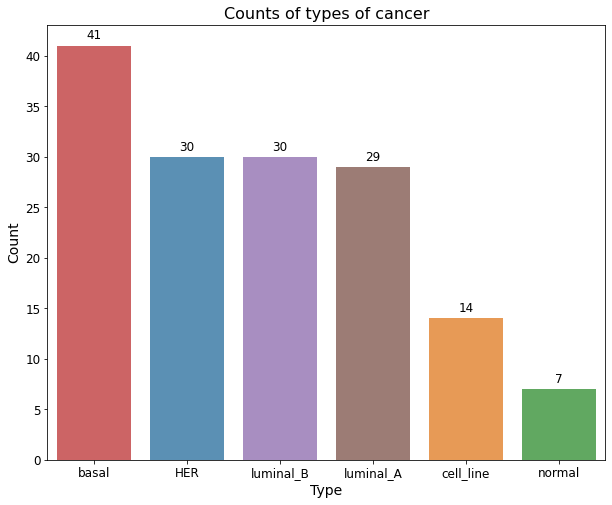

In [45]:
plt.figure(figsize=(10, 8))

value_counts = df["type"].value_counts().reset_index()
value_counts.columns = ['type', 'count']


ax = sns.barplot(x='type', y='count', data=value_counts, palette=color_map, hue="type", alpha=0.8)
ax.set_title('Counts of types of cancer', fontsize=16)
ax.set_xlabel('Type', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.tick_params(labelsize=12)
plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=12)


plt.show()


In [46]:
print("Min value of gene expression is ", genes_matrix.min())
print("Max value of gene expression is ", genes_matrix.max())
print("Total variance in gene matrix is ", genes_matrix.var())

Min value of gene expression is  2.17109972663613
Max value of gene expression is  14.9701002149474
Total variance in gene matrix is  4.526885278734545


## PCA


In [47]:
%%time

#using PCA to see how many companents we need to achieve good explained variance

pca = PCA(n_components=100)
pca.fit(genes_matrix)

CPU times: user 12.3 s, sys: 7.14 s, total: 19.4 s
Wall time: 6.41 s


PCA(n_components=100)

In [48]:
%%time 

genes_matrix_pca = pca.transform(genes_matrix)

CPU times: user 354 ms, sys: 226 ms, total: 580 ms
Wall time: 262 ms


In [49]:
genes_matrix_pca.shape

(151, 100)

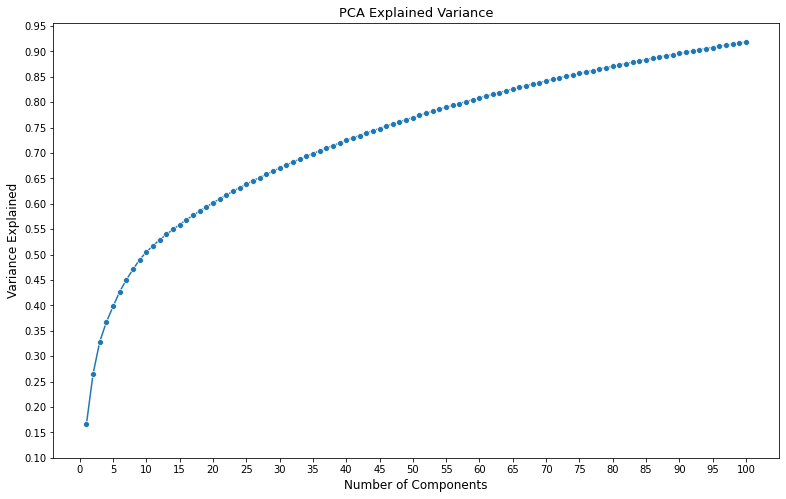

In [50]:
plt.figure(figsize=(13, 8))
sns.lineplot(x=np.arange(1, pca.n_components_ + 1, 1), y=np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.title('PCA Explained Variance', fontsize=13)
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Variance Explained', fontsize=12)
plt.xticks(np.arange(0, 105, 5))
plt.yticks(np.arange(0.1, 1, 0.05))
plt.show()

In [51]:
print("ratio of VAR explained by  first 100 PCs = ", np.sum(pca.explained_variance_ratio_))

ratio of VAR explained by  first 100 PCs =  0.9182928533817157


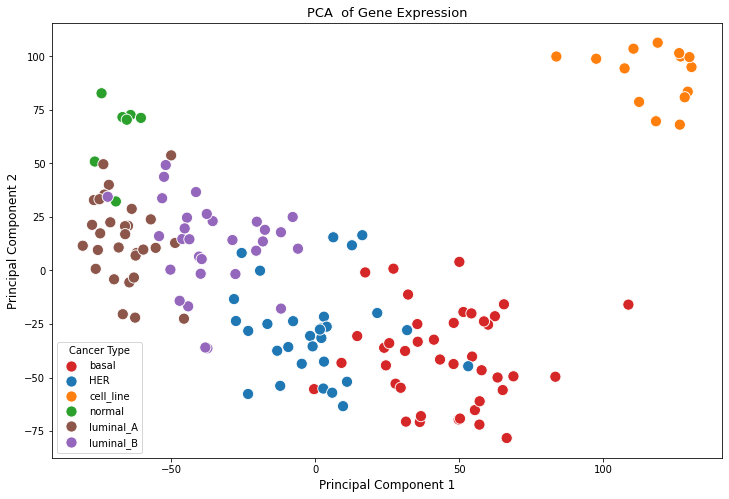

In [52]:
### let's try to visualize first 2 components from pca

pca_df = pd.DataFrame(genes_matrix_pca[:, :2], columns=['PCA1', 'PCA2'])
pca_df['Label'] = cancer_labels

plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Label', palette=color_map, s=125)

plt.title('PCA  of Gene Expression', fontsize=13)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Cancer Type')
plt.show()

## T-SNE visualization

In [53]:

tsne = TSNE(n_components=2,
            init="pca",
            learning_rate=100,
            random_state=1,
            n_jobs=-1,
            perplexity=12,
            early_exaggeration=4
            )





genes_matrix_tsne = tsne.fit_transform(genes_matrix)

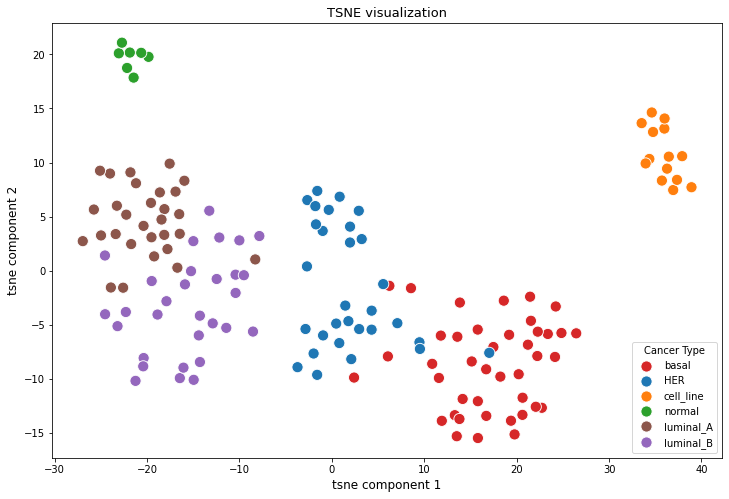

In [54]:
tsne_df = pd.DataFrame(genes_matrix_tsne[:, :2], columns=['PCA1', 'PCA2'])
tsne_df['Label'] = cancer_labels

plt.figure(figsize=(12, 8))
sns.scatterplot(data=tsne_df, x='PCA1', y='PCA2', hue='Label', palette=color_map, s=125)

plt.title('TSNE visualization', fontsize=13)
plt.xlabel('tsne component 1', fontsize=12)
plt.ylabel('tsne component 2', fontsize=12)
plt.legend(title='Cancer Type')
plt.show()

TSNE separates classes much better

## Gene selection

### Mutual Information

In [20]:
%%time


mi_scores = mutual_info_classif(genes_matrix, labels, random_state=1)

CPU times: user 5min 41s, sys: 2.11 s, total: 5min 43s
Wall time: 5min


In [55]:
mi_df = pd.read_csv("genes_MI.csv").drop("Unnamed: 0", axis=1)
mi_df.head(5)


,gene,MI
0,211519_s_at,0.917965
1,210052_s_at,0.866330
2,202240_at,0.845233
3,218542_at,0.845002
4,202779_s_at,0.819782


In [24]:

mi_df = pd.DataFrame({"gene" : genes_names, 
                     "MI" : mi_scores})

mi_df = mi_df.sort_values(by="MI", ascending=False)

mi_df.to_csv("genes_MI.csv")


mi_df.head(10)

In [56]:
mi_df["MI"].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999])

0.100    0.016808
0.200    0.051215
0.300    0.078727
0.400    0.104878
0.500    0.132005
0.600    0.161793
0.700    0.197437
0.800    0.245639
0.900    0.321369
0.950    0.392730
0.990    0.539691
0.999    0.704228
Name: MI, dtype: float64

In [24]:
###a lot of features have very low MI


### Chi-Squared statistic

In [57]:
%%time 

chi2_scores, chi2_pvals = chi2(genes_matrix, labels)


##IMPORTANT STEP: pvalue adjustment
_ , chi2_pvals_adj = fdrcorrection(chi2_pvals, alpha=0.01)


chi2_df = pd.DataFrame({"gene" : genes_names, 
                     "CHI2" : chi2_scores,
                      "p_value" : chi2_pvals,
                      "p_value_adj" : chi2_pvals_adj})

chi2_df = chi2_df.sort_values(by="CHI2", ascending=False)

chi2_df.to_csv("genes_chi2.csv")


chi2_df.head(10)

CPU times: user 526 ms, sys: 330 ms, total: 856 ms
Wall time: 541 ms


,gene,CHI2,p_value,p_value_adj
37495,228241_at,214.481735,2.258643e-44,1.234913e-39
46588,237339_at,146.800900,6.402447e-30,1.750269e-25
15824,206378_at,145.705457,1.094978e-29,1.995597e-25
14672,205225_at,135.837039,1.371714e-27,1.874962e-23
18587,209173_at,128.352468,5.322940e-26,5.820635e-22
14456,205009_at,122.070630,1.143046e-24,1.041601e-20
37808,228554_at,118.543040,6.386788e-24,4.988537e-20
14491,205044_at,118.189847,7.586930e-24,5.185192e-20
33137,223861_at,116.467687,1.756418e-23,1.067024e-19
46335,237086_at,111.836230,1.676334e-22,9.165359e-19


#### TODO:
- drop all features that have both lower CHI2 and MI

## Filtering genes

In [58]:
#### selecting only features that have Mutual Information  >= 0.5

mi_selected_genes = mi_df[mi_df["MI"] >= 0.5]

mi_selected_genes

,gene,MI
0,211519_s_at,0.917965
1,210052_s_at,0.866330
2,202240_at,0.845233
3,218542_at,0.845002
4,202779_s_at,0.819782
...,...,...
853,227020_at,0.500298
854,220036_s_at,0.500290
855,1555943_at,0.500095
856,235847_at,0.500090


In [59]:
### selecting genes with chi2 pvalue  < 0.01

chi2_selected_genes  = chi2_df[chi2_df["p_value_adj"] < 0.01]
chi2_selected_genes

,gene,CHI2,p_value,p_value_adj
37495,228241_at,214.481735,2.258643e-44,1.234913e-39
46588,237339_at,146.800900,6.402447e-30,1.750269e-25
15824,206378_at,145.705457,1.094978e-29,1.995597e-25
14672,205225_at,135.837039,1.371714e-27,1.874962e-23
18587,209173_at,128.352468,5.322940e-26,5.820635e-22
...,...,...,...,...
13533,204086_at,25.252954,1.245051e-04,9.628450e-03
28777,219493_at,25.226978,1.259528e-04,9.726655e-03
28584,219300_s_at,25.209513,1.269357e-04,9.788726e-03
36883,227629_at,25.193203,1.278603e-04,9.846142e-03


In [60]:
selected_genes = list(set(list(mi_selected_genes["gene"]) + list(chi2_selected_genes["gene"])))


genes_selected_both = list(set(mi_selected_genes["gene"]) & set(chi2_selected_genes["gene"]))

print("Number of genes selected by both MI and Chi2:", len(genes_selected_both))
print("Number of genes selected by either MI or Chi2: ",len(selected_genes))

##The most valuable are probably from interesection
genes_selected_both[:10]

Number of genes selected by both MI and Chi2: 240
Number of genes selected by either MI or Chi2:  1329


['223204_at',
 '211110_s_at',
 '218355_at',
 '202095_s_at',
 '208103_s_at',
 '1552619_a_at',
 '219978_s_at',
 '222835_at',
 '220651_s_at',
 '229088_at']

### try  to visualize using only very important genes

#### PCA on selected genes

In [61]:
genes_matrix_reduced = df[genes_selected_both].values

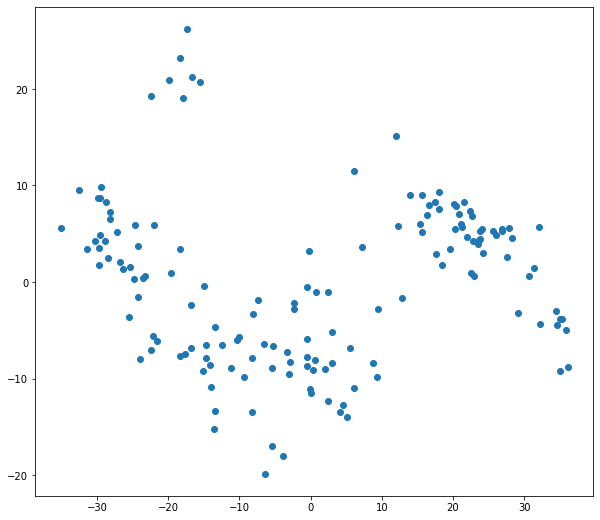

In [62]:
pca_red = PCA(n_components=2)



genes_matrix_reduced_pca = pca_red.fit_transform(genes_matrix_reduced)


plt.figure(figsize=(10, 9))
plt.scatter(genes_matrix_reduced_pca.T[0], genes_matrix_reduced_pca.T[1])

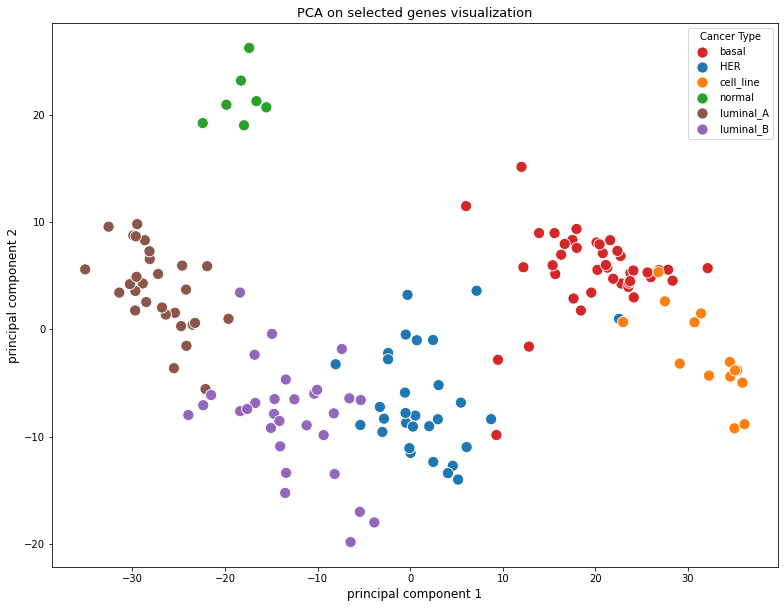

In [63]:
pca_red_df = pd.DataFrame(genes_matrix_reduced_pca[:, :2], columns=['PCA1', 'PCA2'])
pca_red_df['Label'] = cancer_labels

plt.figure(figsize=(13, 10))
sns.scatterplot(data=pca_red_df, x='PCA1', y='PCA2', hue='Label', palette=color_map, s=125)

plt.title('PCA on selected genes visualization', fontsize=13)
plt.xlabel('principal component 1', fontsize=12)
plt.ylabel('principal component 2', fontsize=12)
plt.legend(title='Cancer Type')
plt.show()

### TSNE on selected genes

In [64]:
tsne_red = TSNE(n_components=2,
            init="pca",
            learning_rate=250,
            random_state=1,
            n_jobs=-1,
            perplexity=8, 
            early_exaggeration=10
            )


genes_matrix_reduced_tsne = tsne_red.fit_transform(genes_matrix_reduced)

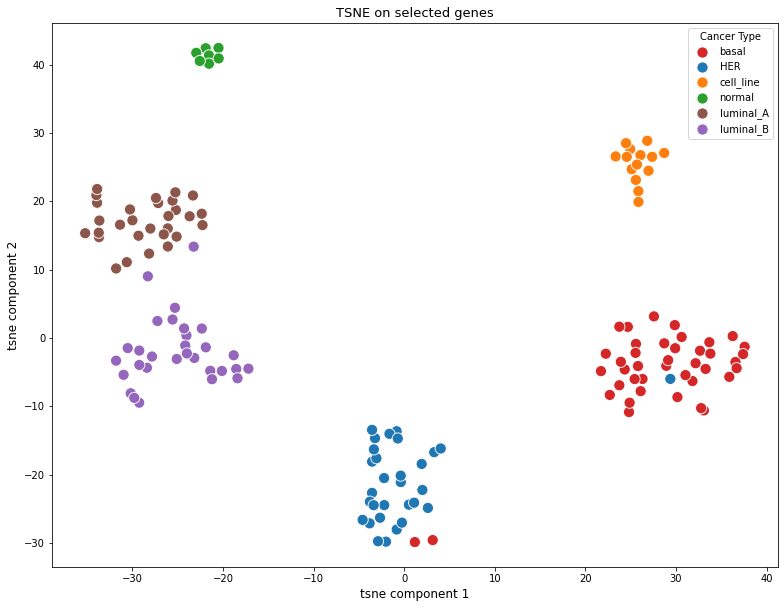

In [65]:
tsne_red_df = pd.DataFrame(genes_matrix_reduced_tsne[:, :2], columns=['tsne_component1', 'tsne_component2'])
tsne_red_df['Label'] = cancer_labels

plt.figure(figsize=(13, 10))
sns.scatterplot(data=tsne_red_df, x='tsne_component1', y='tsne_component2', hue='Label', palette=color_map, s=125)

plt.title('TSNE on selected genes', fontsize=13)
plt.xlabel('tsne component 1', fontsize=12)
plt.ylabel('tsne component 2', fontsize=12)
plt.legend(title='Cancer Type')
plt.show()

In [66]:
### We;ve got a fairly nice separation using tsne on selected genes

### TODO:
  - try clustering to identify how many clusters(types of cancers) are a good choice
  - use Logistic Regression one vs all to select genes corresponding to each type of cancer
  - come up with a set of important genes to look at for  each cancer type

### Identifying subtypes

Text(0, 0.5, 'Inertia')

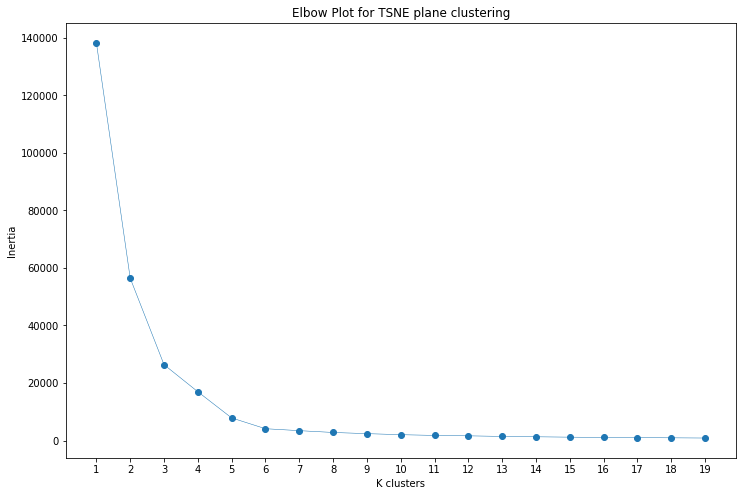

In [67]:

inertias = []

for k in range(1, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(genes_matrix_reduced_tsne)
    inertias.append(kmeans.inertia_)
    
plt.figure(figsize=(12, 8))
plt.title("Elbow Plot for TSNE plane clustering", fontsize=12)
plt.plot(np.arange(1, 20, 1), inertias, marker="o", lw=0.5)
plt.xticks(np.arange(1, 20, 1))
plt.xlabel("K clusters")
plt.ylabel("Inertia")

## Optimizing params of T-SNE

In [83]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.stats import spearmanr
from scipy.spatial.distance import pdist

def compute_KNN_score(X_high_dim, X_low_dim, n_neighbors=5):
    nn_high = NearestNeighbors(n_neighbors=n_neighbors).fit(X_high_dim)
    _, indices_high = nn_high.kneighbors(X_high_dim)
    
    nn_low = NearestNeighbors(n_neighbors=n_neighbors).fit(X_low_dim)
    _, indices_low = nn_low.kneighbors(X_low_dim)
    
    score = sum(len(set(high).intersection(set(low))) for high, low in zip(indices_high, indices_low)) / (len(X_high_dim) * n_neighbors)
    return score

def compute_KNC_score(X_high_dim, X_low_dim, labels, n_neighbors=5):
    classes = np.unique(labels)
    means_high = np.array([X_high_dim[labels == c].mean(axis=0) for c in classes])
    means_low = np.array([X_low_dim[labels == c].mean(axis=0) for c in classes])
    
    nn_high = NearestNeighbors(n_neighbors=n_neighbors).fit(means_high)
    _, indices_high = nn_high.kneighbors(means_high)
    
    nn_low = NearestNeighbors(n_neighbors=n_neighbors).fit(means_low)
    _, indices_low = nn_low.kneighbors(means_low)
    
    score = sum(len(set(high).intersection(set(low))) for high, low in zip(indices_high, indices_low)) / (len(classes) * n_neighbors)
    return score

def compute_CPD_score(X_high_dim, X_low_dim):
    distances_high = pdist(X_high_dim, 'euclidean')
    distances_low = pdist(X_low_dim, 'euclidean')
    
    correlation, _ = spearmanr(distances_high, distances_low)
    return correlation



def save_tsne_plot(X_low_dim, labels, trial_id):
    plt.figure(figsize=(8, 6))
    for i in np.unique(labels):
        plt.scatter(X_low_dim[labels == i, 0], X_low_dim[labels == i, 1], label=i)
    plt.title(f't-SNE Visualization Trial {trial_id}')
    plt.legend()
    plt.savefig(f'tsne_trials/trial_{trial_id}.png')
    plt.close()

def objective(trial):
    X_high_dim = genes_matrix_reduced
    y = labels
    n_classes = len(np.unique(y))
    
    ##TSNE PARAMS
    perplexity = trial.suggest_float('perplexity', 5, 50)
    learning_rate = trial.suggest_float('learning_rate', 10, 1000)
    n_iter = trial.suggest_int('n_iter', 250, 5000)
    early_exaggeration= trial.suggest_int("early_exaggeration", 1, 20)
    
    
    
    tsne = TSNE(perplexity=perplexity,
                learning_rate=learning_rate,
                n_iter=n_iter,
                early_exaggeration = early_exaggeration,
                random_state=42)
    X_low_dim = tsne.fit_transform(X_high_dim)
    
    knn_score = compute_KNN_score(X_high_dim, X_low_dim, n_neighbors=4) #microscopic structure
    knc_score = compute_KNC_score(X_high_dim, X_low_dim, y, n_neighbors=n_classes) 
    cpd_score = compute_CPD_score(X_high_dim, X_low_dim) #Global structure
    
    average_score = (0.8 * knn_score + knc_score +  1.2 * cpd_score) / 3
    save_tsne_plot(X_low_dim, y, trial.number)
    return average_score


os.makedirs('tsne_trials', exist_ok=True)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)




[I 2024-02-11 12:59:50,792] A new study created in memory with name: no-name-c394321b-c890-41d3-9a61-8082adf3d25e
[I 2024-02-11 12:59:51,972] Trial 0 finished with value: 0.7129198454933993 and parameters: {'perplexity': 6.049132576089289, 'learning_rate': 370.76209543654363, 'n_iter': 4227, 'early_exaggeration': 19}. Best is trial 0 with value: 0.7129198454933993.
[I 2024-02-11 12:59:52,945] Trial 1 finished with value: 0.8002049653402793 and parameters: {'perplexity': 7.751096320474264, 'learning_rate': 318.5147376048912, 'n_iter': 805, 'early_exaggeration': 16}. Best is trial 1 with value: 0.8002049653402793.
[I 2024-02-11 12:59:54,201] Trial 2 finished with value: 0.8261540688212813 and parameters: {'perplexity': 47.96995098471816, 'learning_rate': 981.7430227106619, 'n_iter': 4888, 'early_exaggeration': 2}. Best is trial 2 with value: 0.8261540688212813.
[I 2024-02-11 12:59:55,481] Trial 3 finished with value: 0.8743841951507992 and parameters: {'perplexity': 37.59663063500265, 'l

[I 2024-02-11 13:00:41,451] Trial 32 finished with value: 0.8945238499043976 and parameters: {'perplexity': 7.955010040730219, 'learning_rate': 191.3581265201655, 'n_iter': 3362, 'early_exaggeration': 19}. Best is trial 28 with value: 0.8984713654217286.
[I 2024-02-11 13:00:43,231] Trial 33 finished with value: 0.8996416393149328 and parameters: {'perplexity': 8.10141484987908, 'learning_rate': 53.402729689594906, 'n_iter': 3454, 'early_exaggeration': 19}. Best is trial 33 with value: 0.8996416393149328.
[I 2024-02-11 13:00:45,814] Trial 34 finished with value: 0.8872192108564629 and parameters: {'perplexity': 6.991028594626574, 'learning_rate': 65.78655710542854, 'n_iter': 3423, 'early_exaggeration': 18}. Best is trial 33 with value: 0.8996416393149328.
[I 2024-02-11 13:00:48,748] Trial 35 finished with value: 0.8610429672919361 and parameters: {'perplexity': 5.586722750644341, 'learning_rate': 49.928781454574306, 'n_iter': 3138, 'early_exaggeration': 19}. Best is trial 33 with value:

[I 2024-02-11 13:01:36,747] Trial 65 finished with value: 0.8892108208114106 and parameters: {'perplexity': 14.412501383182153, 'learning_rate': 86.92150209032728, 'n_iter': 2879, 'early_exaggeration': 19}. Best is trial 57 with value: 0.9002742870808942.
[I 2024-02-11 13:01:39,196] Trial 66 finished with value: 0.8873579687009139 and parameters: {'perplexity': 18.63918033888817, 'learning_rate': 131.70964607012615, 'n_iter': 3507, 'early_exaggeration': 17}. Best is trial 57 with value: 0.9002742870808942.
[I 2024-02-11 13:01:40,958] Trial 67 finished with value: 0.8920643613201737 and parameters: {'perplexity': 10.689083021895984, 'learning_rate': 47.934076261193276, 'n_iter': 3076, 'early_exaggeration': 19}. Best is trial 57 with value: 0.9002742870808942.
[I 2024-02-11 13:01:43,468] Trial 68 finished with value: 0.8960208649616105 and parameters: {'perplexity': 8.848601006234903, 'learning_rate': 98.92076548443488, 'n_iter': 3369, 'early_exaggeration': 20}. Best is trial 57 with val

[I 2024-02-11 13:02:50,908] Trial 98 finished with value: 0.8930217118066938 and parameters: {'perplexity': 10.164271401833888, 'learning_rate': 97.51291820807171, 'n_iter': 4011, 'early_exaggeration': 19}. Best is trial 57 with value: 0.9002742870808942.
[I 2024-02-11 13:02:52,808] Trial 99 finished with value: 0.8907296374321874 and parameters: {'perplexity': 15.429304546829176, 'learning_rate': 26.51868944302579, 'n_iter': 3626, 'early_exaggeration': 20}. Best is trial 57 with value: 0.9002742870808942.


In [84]:
study.best_params

{'perplexity': 10.790959455639797,
 'learning_rate': 13.520825678985439,
 'n_iter': 3152,
 'early_exaggeration': 18}

### TODO:
 - use results of optuna to justify number chosen params